In [50]:
import pandas as pd

df = pd.read_csv("data/SomervilleHappinessSurvey2015.csv", sep = ",")

df.head()

,D,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


In [51]:
df.describe()

,D,X1,X2,X3,X4,X5,X6
count,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000
mean,0.538462,4.314685,2.538462,3.265734,3.699301,3.615385,4.216783
std,0.500271,0.799820,1.118155,0.992586,0.888383,1.131639,0.848693
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,4.000000,2.000000,3.000000,3.000000,3.000000,4.000000
50%,1.000000,5.000000,3.000000,3.000000,4.000000,4.000000,4.000000
75%,1.000000,5.000000,3.000000,4.000000,4.000000,4.000000,5.000000
max,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


## Handle missing values

In [52]:
num_missing = (df[df.columns] == 0).sum()

print(num_missing)

D     66
X1     0
X2     0
X3     0
X4     0
X5     0
X6     0
dtype: int64


As it can be seen, there is no missing values.

## Data Analysis

In [7]:
# !python3.7 -m pip install seaborn

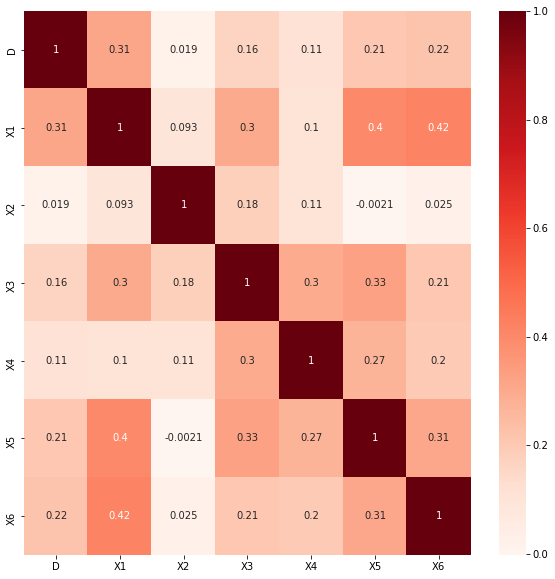

In [53]:
#Using Pearson Correlation
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [54]:
#Correlation with output variable
cor_target = abs(cor['D']).sort_values(ascending=False)[1:]

cor_target

X1    0.312740
X6    0.220729
X5    0.206685
X3    0.163639
X4    0.113356
X2    0.019368
Name: D, dtype: float64

By looking at results, we can say that attribute X1 has the most correlation with the target among other features.

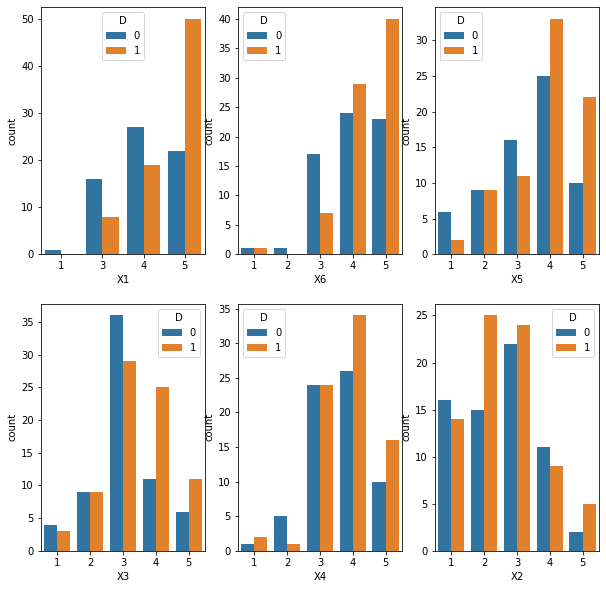

In [55]:
import math
from matplotlib import rcParams
import numpy as np

# figure size in inches
rcParams['figure.figsize'] = 10,10

def plot_multiple_countplots(df, cols):
    num_plots = len(cols)
    num_cols = math.ceil(np.sqrt(num_plots))
    num_rows = math.ceil(num_plots/num_cols)
        
    fig, axs = plt.subplots(num_rows, num_cols)
    
    for ind, col in enumerate(cols):
        i = math.floor(ind/num_cols)
        j = ind - i*num_cols
        
        if num_rows == 1:
            if num_cols == 1:
                sns.countplot(x=df[col], hue=df["D"], ax=axs)
            else:
                sns.countplot(x=df[col], hue=df["D"], ax=axs[j])
        else:
            sns.countplot(x=df[col], hue=df["D"], ax=axs[i, j])
            
            
plot_multiple_countplots(df, cor_target.keys())

## Split Dataset into Training and Testing sets

In [56]:
class_df = df['D']
class_df.head()

0    0
1    0
2    1
3    0
4    0
Name: D, dtype: int64

In [57]:
features_df=df.drop('D',axis=1)
features_df.head()

,X1,X2,X3,X4,X5,X6
0,3,3,3,4,2,4
1,3,2,3,5,4,3
2,5,3,3,3,3,5
3,5,4,3,3,3,5
4,5,4,3,3,3,5


In [58]:
import numpy as np
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features_df,class_df, test_size=0.2, random_state=42)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(114, 6)
(29, 6)
(114,)
(29,)


## Decision Tree

### Grid Search

In [59]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier 

param_grid = {
    'max_depth': [3, 4, 5, 6],
    'max_features' : ['auto', 'sqrt', 'log2']
}


grid_search = GridSearchCV(estimator = DecisionTreeClassifier(), param_grid = param_grid, cv = 3)

grid_search.fit(x_train, y_train)
grid_search.best_params_

{'max_depth': 3, 'max_features': 'log2'}

### Accuracy

In [60]:
best_grid = grid_search.best_estimator_

print("Decision Trees's Accuracy: ", best_grid.score(x_test, y_test))

Decision Trees's Accuracy:  0.4827586206896552


### Confusion Matrix

In [61]:
from sklearn.metrics import confusion_matrix

predictions = best_grid.predict(x_test)
confusion_matrix(y_test, predictions)

array([[ 3, 12],
       [ 3, 11]])

### Ghraphical view

In [32]:
# !pip3 install pydotplus

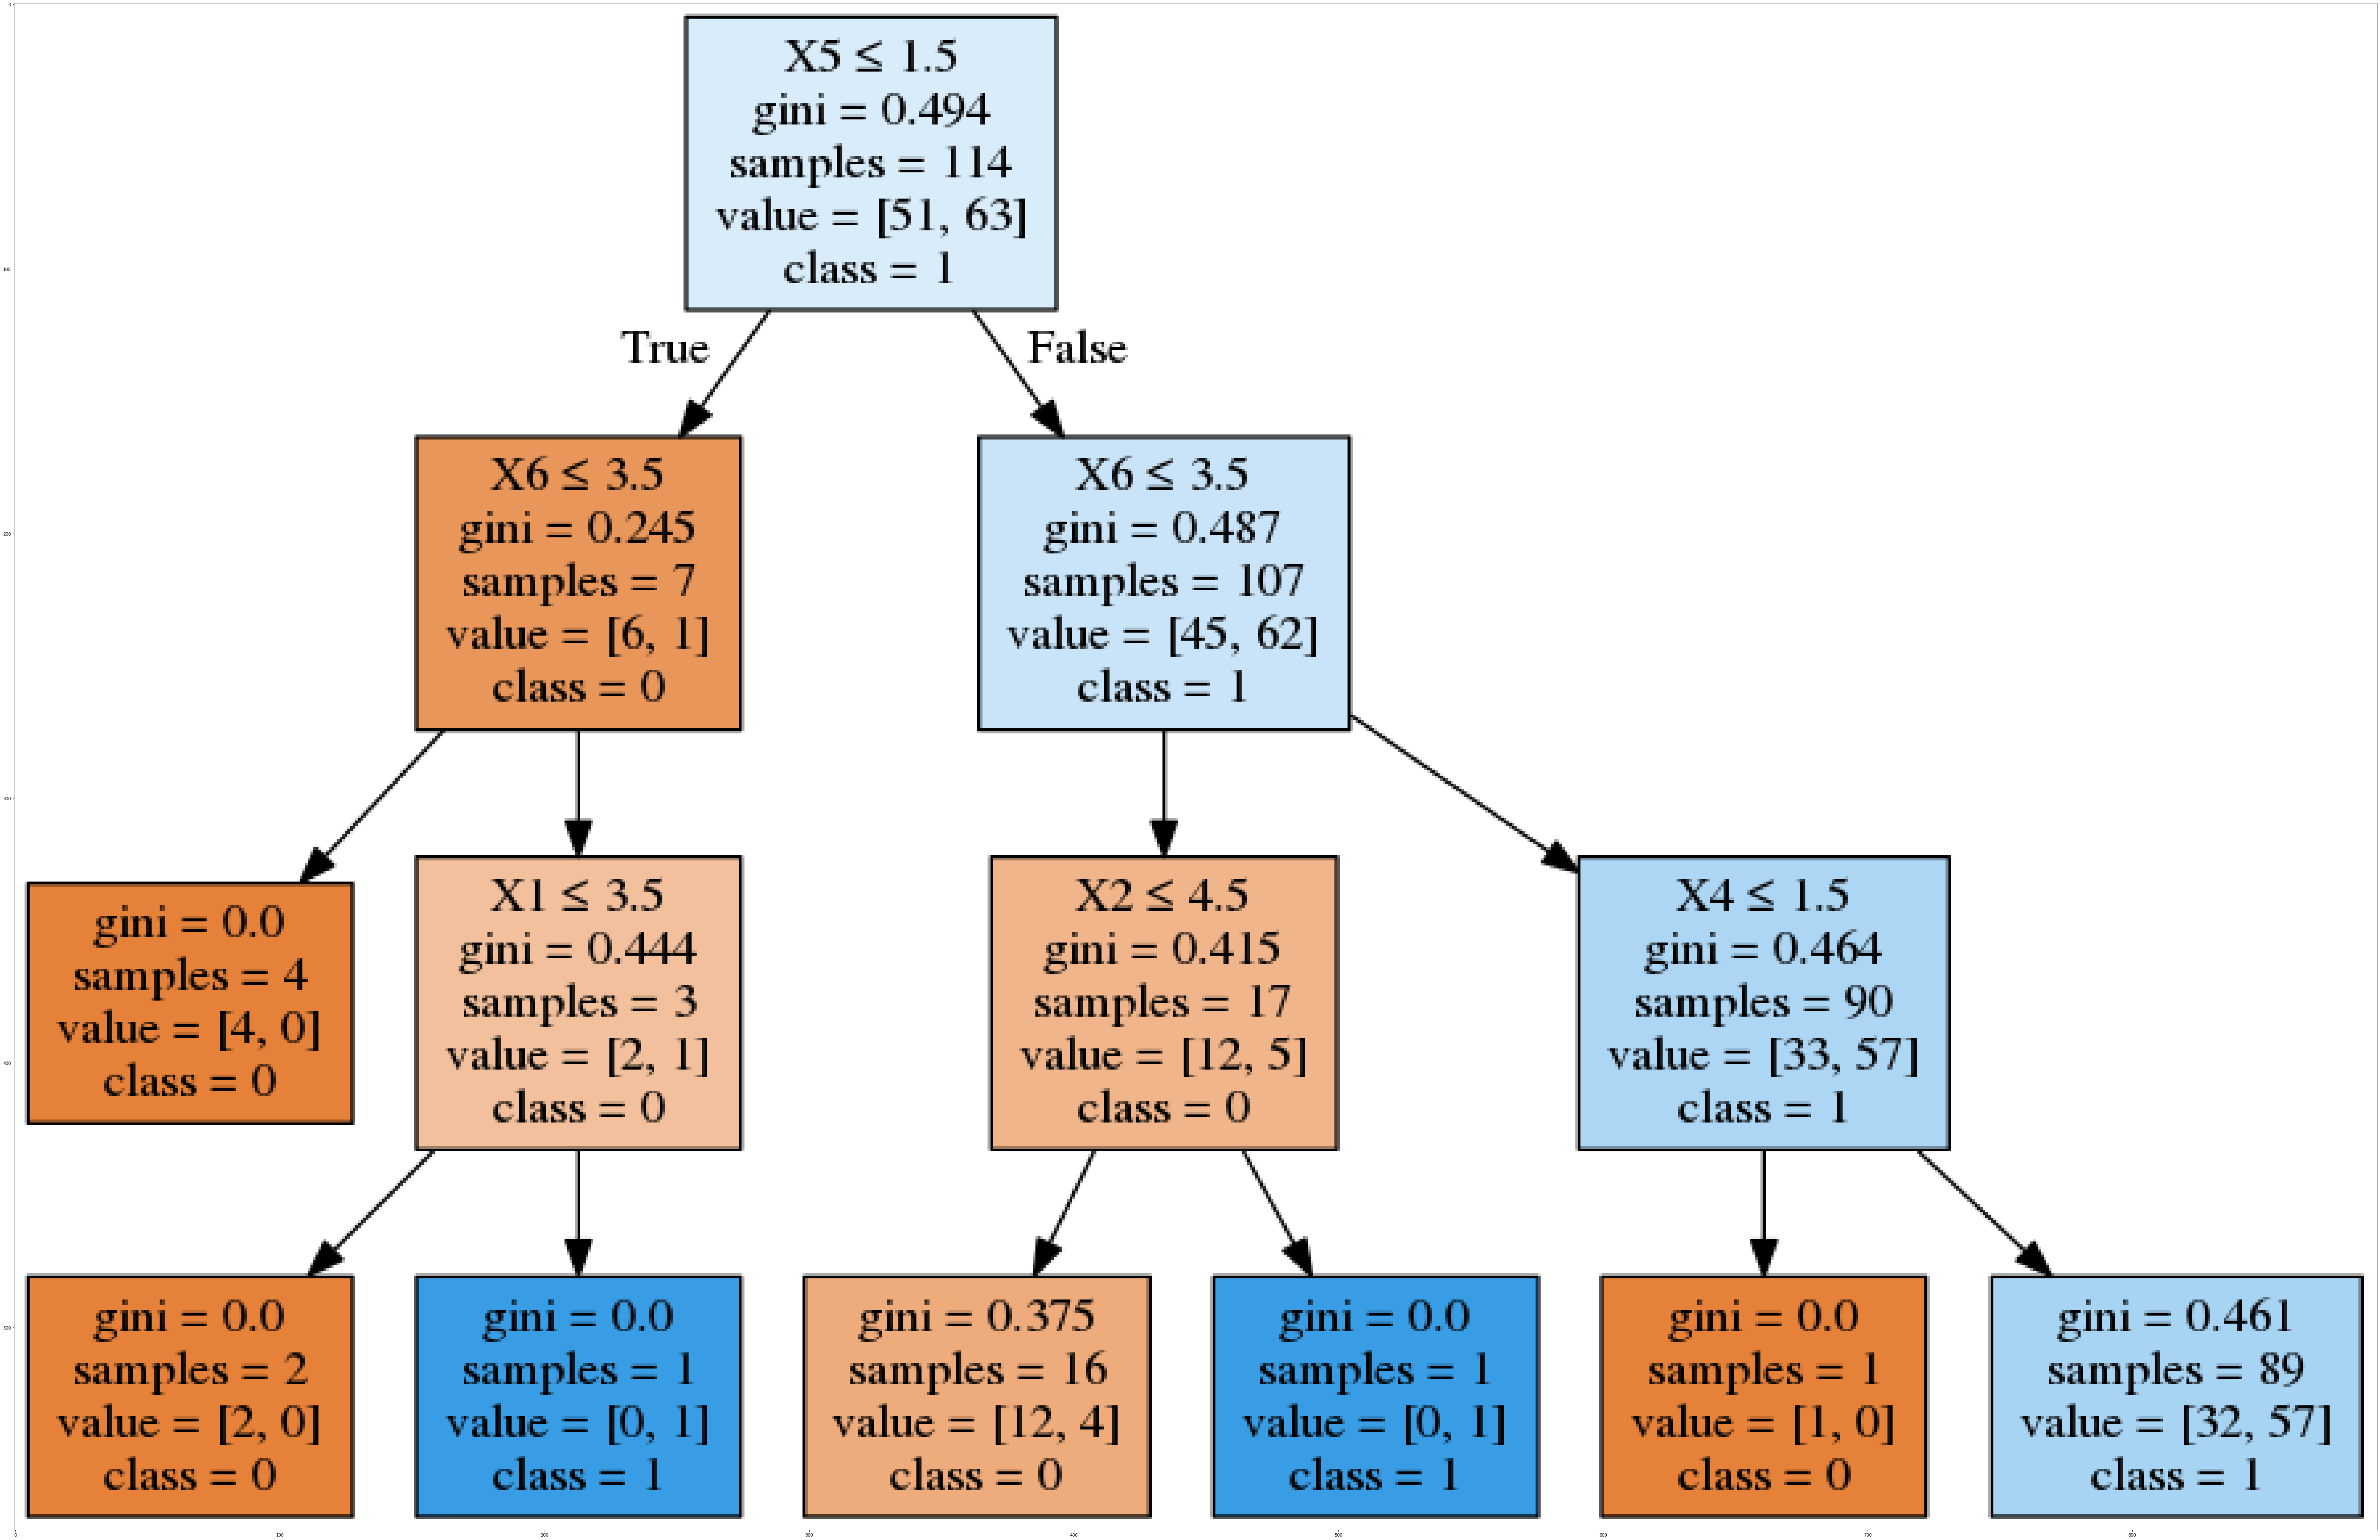

In [62]:
from sklearn.externals.six import StringIO
import pydotplus 
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

dot_data = StringIO() 
filename = "decisiontree.png"
featureNames = features_df.columns[:]
targetNames = df["D"].unique().tolist()
targetNames = [str(i) for i in targetNames]

out = tree.export_graphviz(best_grid,feature_names=featureNames, out_file=dot_data, class_names= targetNames, filled=True,  special_characters=True,rotate=False)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)

img = mpimg.imread(filename)

plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

# Bagging

### Grid Search

In [63]:
from sklearn.ensemble import BaggingClassifier

param_grid = {
    'max_samples': [1, 2, 3],
    'max_features':[1, 2, 3, 4],
    'n_estimators': [50, 100, 150, 200]
}


grid_search = GridSearchCV(estimator = BaggingClassifier(), param_grid = param_grid, cv = 3)

grid_search.fit(x_train, y_train)
grid_search.best_params_

{'max_features': 3, 'max_samples': 3, 'n_estimators': 100}

### Accuracy

In [64]:
best_grid = grid_search.best_estimator_

print("Bagging's Accuracy: ", best_grid.score(x_test, y_test))

Bagging's Accuracy:  0.5172413793103449


### Confusion Matrix

In [65]:
predictions = best_grid.predict(x_test)
confusion_matrix(y_test, predictions)

array([[ 2, 13],
       [ 1, 13]])

# Random Forest

### Grid search

In [66]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'max_depth': [3, 4, 5, 6],
    'max_features' : ['auto', 'sqrt', 'log2'],
    'n_estimators': [50, 100, 150, 200]
}


grid_search = GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid, cv = 3)

grid_search.fit(x_train, y_train)
grid_search.best_params_

{'max_depth': 4, 'max_features': 'auto', 'n_estimators': 50}

### Accuracy

In [67]:
best_grid = grid_search.best_estimator_

print("Random Forest's Accuracy: ", best_grid.score(x_test, y_test))

Random Forest's Accuracy:  0.6551724137931034


### Confusion Matrix

In [68]:
predictions = best_grid.predict(x_test)
confusion_matrix(y_test, predictions)

array([[ 7,  8],
       [ 2, 12]])

### Graphical view

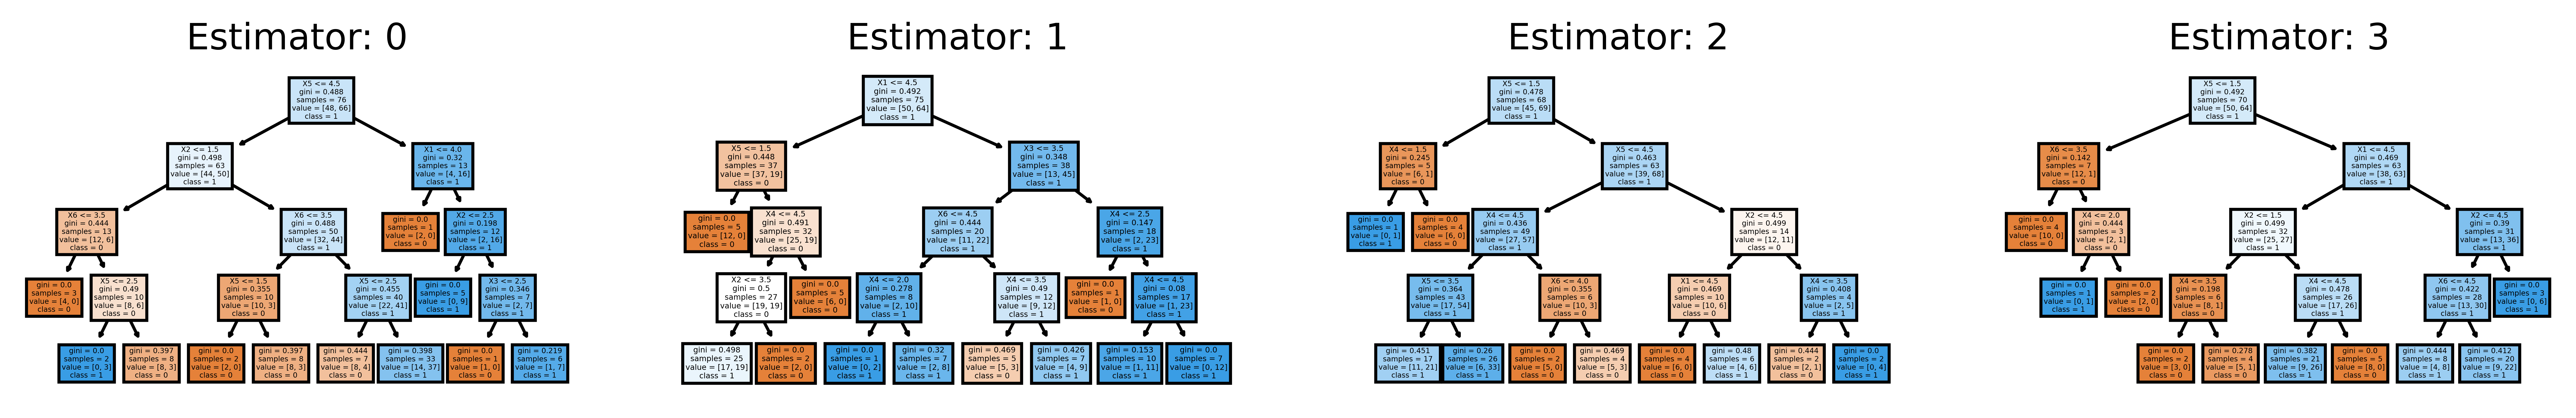

In [69]:
fig, axes = plt.subplots(nrows = 1,ncols = 4,figsize = (15,2), dpi=900)
for index in range(0, 4):
    tree.plot_tree(best_grid.estimators_[index],
                   feature_names = featureNames, 
                   class_names=targetNames,
                   filled = True,
                   ax = axes[index]);

    axes[index].set_title('Estimator: ' + str(index), fontsize = 12)
fig.savefig('rf_4trees.png')

# Gradient Boosting

### Grid Search

In [74]:
from sklearn.ensemble import GradientBoostingClassifier

param_grid = {
    'max_depth': [3, 4, 5, 6],
    'max_features' : ['auto', 'sqrt', 'log2'],
    'n_estimators': [50, 100, 150, 200]
}

grid_search = GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = param_grid, cv = 3)

grid_search.fit(x_train, y_train)
grid_search.best_params_

{'max_depth': 5, 'max_features': 'auto', 'n_estimators': 150}

### Accuracy

In [75]:
best_grid = grid_search.best_estimator_

print("Gradient Boosting's Accuracy: ", best_grid.score(x_test, y_test))

Gradient Boosting's Accuracy:  0.5862068965517241


### Confusion Matrix

In [76]:
predictions = best_grid.predict(x_test)
confusion_matrix(y_test, predictions)

array([[9, 6],
       [6, 8]])